In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from scipy.misc import derivative

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

***some notes***

I've also tried next techniques, like
- under and oversampling (like SMOTE, ADASYN, ..)
- as well as dimensionality reduction (PCA)
- as well as feature selection (SelectKBest by chi2)
- as well as removing outliers (with IsolationForest)

but they didn't improve the quality of this specific model

In [3]:
def scale_train_test(x_train, x_test, scaler, columns_to_scale):
    # fit standard scaler only on train data
    scaler.fit(x_train[columns_to_scale])

    # transform train and test columns with scaler
    x_train_scaled = scaler.transform(x_train[columns_to_scale])
    x_test_scaled = scaler.transform(x_test[columns_to_scale])

    # update x values with transformed ones
    x_train.loc[:,columns_to_scale] = x_train_scaled
    x_test.loc[:,columns_to_scale] = x_test_scaled

    return x_train, x_test

# read data

In [4]:
# read data
df_path = './data/df.csv'
df = pd.read_csv(df_path)
df.head()

,is_fraud,transaction_amount,relative_timestamp,F1,F2,F3,F4,F5,F6,F7,...,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,0,118.44,159609.0,1.928977,-0.745709,-1.742981,-0.247731,-0.379232,-1.504379,0.426988,...,-0.096171,0.153526,-0.001283,0.631590,0.130582,0.758711,-0.113741,-0.063939,0.795595,-2.200074
1,0,1.98,162525.0,2.060450,-0.136926,-1.085910,0.430300,-0.254977,-1.247417,0.104193,...,-0.302288,-0.795267,0.355477,0.013651,-0.340015,0.199361,-0.078557,-0.062377,0.921937,0.216959
2,0,103.00,58956.0,1.114014,-1.533296,0.741385,-1.385897,-1.241643,1.088519,-1.433041,...,0.140363,0.783574,0.082555,-0.615175,-0.036441,-0.006456,0.109368,0.032635,0.225000,-2.467540
3,0,16.70,148842.0,0.514410,1.389934,-1.091181,1.604760,0.460984,-0.381953,-0.599145,...,-1.670931,-0.854670,0.130428,0.789378,0.909599,-0.692159,-0.033316,0.096833,0.586722,1.187643
4,0,110.14,125542.0,-0.849330,0.399191,-0.319642,-1.220384,1.062371,1.752440,0.558836,...,0.134113,0.278606,0.198983,-0.936208,-0.477630,-0.087217,0.035566,0.090183,0.569712,-1.485808


In [5]:
# split on features and target 
X = df.drop('is_fraud', axis=1)
Y = df['is_fraud']

# columns F29 and F30 have missing values, fill na with mean
X.fillna(X.mean(), inplace=True)

# focal loss
Focal loss was designed for object detection purpose, where there is  extreme foreground-background class imbalance.

https://arxiv.org/pdf/1708.02002.pdf

inspired by https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca

In [6]:
def focal_loss_lgb(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p) + (1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

def focal_loss_lgb_eval_error(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False


alpha=0.25
gamma=1.

focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=alpha, gamma=gamma)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=alpha, gamma=gamma)

def sigmoid(x): return 1./(1. +  np.exp(-x))


class FocalLGBMClassifier(lgb.LGBMClassifier):
    
    def predict_proba(self, *args, **kwargs):
        """Redefining predict_proba(), because when using custom loss function, 
        the raw predictions are not passed through a sigmoid to represent probabilitie
        """
        result = super().predict_proba(*args, **kwargs)
        return sigmoid(result)

In [7]:
# LGBMClassifier with focal loss
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
f1_scores = []
scores = []
for train_index, test_index in skf.split(X, Y):
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y.loc[train_index], Y.loc[test_index]
    
    # scale features
    scaler = StandardScaler()
    columns_to_scale = ['transaction_amount','relative_timestamp']
    x_train, x_test = scale_train_test(x_train, x_test, scaler, columns_to_scale)
    
    # train a model
    model = FocalLGBMClassifier(
        num_leaves = 70,
        n_estimators = 100,
        random_state = 42,
        class_weight='balanced', 
        objective = focal_loss) # or objective='binary' 

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    f1_scores.append(f1)
    scores.append((p, r, f1))

In [8]:
print(round(np.mean(f1_scores),2))
scores

0.86


[(0.9058823529411765, 0.7777777777777778, 0.8369565217391305),
 (0.9058823529411765, 0.7777777777777778, 0.8369565217391305),
 (0.9512195121951219, 0.7959183673469388, 0.8666666666666666),
 (0.9753086419753086, 0.8061224489795918, 0.88268156424581),
 (0.9021739130434783, 0.8469387755102041, 0.8736842105263158)]

# remove outliers 

In [9]:
class OutliersTransformer():    
    def __init__(self, features, coef=3):
        self.features = features
        self.coef = coef
        self.boundaries = {}
        
    def fit(self, x, y):
        # define upper and lower boundaries for each feature 
        # by non-fraud transactions only
        for f in self.features:        
            x_0 = x[y == 0]
            lower, upper = self.iqr_outliers_boundaries(x_0[f], self.coef)
            self.boundaries[f]=(lower, upper)
        return self
    
    def transform(self, x, y=None):   
        # update outliers values
        # at non-fraud transactions only
        if y is not None:
            for f in self.features: 
                lower, upper = self.boundaries[f]
                x_0 = x[y == 0]
                update_index = x.loc[x_0.index].loc[(x[f]<lower)|(x[f]>upper)].index
                x.loc[update_index, f] = (lower + upper) / 2
        return x
    
    def iqr_outliers_boundaries(self, data, coef=3):
        # calculate interquartile range
        q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
        iqr = q75 - q25

        # calculate the outlier cutoff
        cut_off = iqr * coef
        lower, upper = q25 - cut_off, q75 + cut_off
        return lower, upper

# ensemble 
- LGBMClassifier + focal loss 
- LogisticRegression + remove ouliers

In [10]:
# Soft Voting Classifier
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
f1_scores = []
scores = []
for train_index, test_index in skf.split(X, Y):
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y.loc[train_index], Y.loc[test_index]
    
    # scale features
    scaler = StandardScaler()
    columns_to_scale = ['transaction_amount','relative_timestamp']
    x_train, x_test = scale_train_test(x_train, x_test, scaler, columns_to_scale)
    
    # build and train the model
    clf1 = FocalLGBMClassifier(
        num_leaves = 70,
        n_estimators = 100,
        random_state = 42,
        class_weight='balanced', 
        objective = focal_loss)
    
    corr_features = ['F4', 'F10', 'F11', 'F12', 'F14']
    clf2 = Pipeline(steps=[('outliers', OutliersTransformer(corr_features, 3)),
                           ('model', LogisticRegression())])
    
    voting = VotingClassifier(estimators=[('lgb', clf1), ('lr', clf2)], voting='soft', weights=(0.9,0.1))
    voting = voting.fit(x_train, y_train)
    
    # make prediction
    y_pred = voting.predict(x_test)
    
    # evaluate the quality
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    f1_scores.append(f1)
    scores.append((p, r, f1))

In [11]:
print(round(np.mean(f1_scores),2))
scores

0.86


[(0.9294117647058824, 0.797979797979798, 0.8586956521739131),
 (0.9285714285714286, 0.7878787878787878, 0.8524590163934426),
 (0.9629629629629629, 0.7959183673469388, 0.871508379888268),
 (0.9625, 0.7857142857142857, 0.8651685393258427),
 (0.9111111111111111, 0.8367346938775511, 0.8723404255319148)]

# model parameters estimation

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13, stratify=Y)

In [13]:
# scale features
scaler = StandardScaler()
columns_to_scale = ['transaction_amount','relative_timestamp']
x_train, x_test = scale_train_test(x_train, x_test, scaler, columns_to_scale)
    
# build the model
clf1 = FocalLGBMClassifier(
        random_state = 42,
        class_weight='balanced', 
        objective = focal_loss)
    
corr_features = ['F4', 'F10', 'F11', 'F12', 'F14']
clf2 = Pipeline(steps=[('outliers', OutliersTransformer(corr_features, 3)),
                           ('model', LogisticRegression())])
    
voting = VotingClassifier(estimators=[('lgb', clf1), ('lr', clf2)], voting='soft', weights=(0.9,0.1))

In [14]:
clf2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'outliers', 'model', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

In [15]:
clf1.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [16]:
# define grid search model parameters
grid_params = {'lr__model__C' : [0.5,1,1.5], 
               'lr__model__penalty': ['l1', 'l2'],
               'lgb__n_estimators':[100,150], 
               'lgb__num_leaves':[30,70]}
grid = GridSearchCV(estimator=voting, param_grid=grid_params, cv=2, scoring='f1_weighted', n_jobs=-1)
grid = grid.fit(x_train, y_train)

# model with best parameters
estimator = grid.best_estimator_

In [17]:
# print(estimator.get_params())

In [18]:
# train model
estimator = estimator.fit(x_train, y_train)

# make prediction
y_pred = estimator.predict(x_test)
y_scores = estimator.predict_proba(x_test)

# metrics and curve

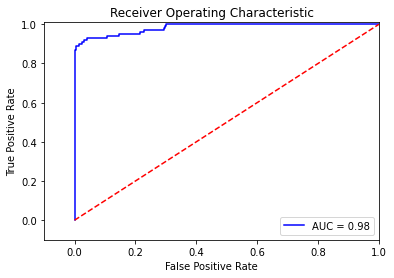

In [19]:
# evaluate the quality
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# check roc_curve 
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr,tpr)

# plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.82      0.89        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
coef = cohen_kappa_score(y_test, y_pred)
print(f"Cohen’s kappa coefficient is {coef:.2f}" )

Cohen’s kappa coefficient is 0.89
